# A NOTEBOOK TO RUN NETWORK ANALYSIS ON SURFACE AREA DATA AVERAGED OVER CLUSTERS OF HCP PARCELS
Clusters of parcels are generated in R. Absolute surface area was averaged within the clusters and the data saved to the shared folder.

In [1]:
# Import packages and scripts
import sys
from pathlib import Path
import pandas as pd
import scipy
from graph_tool.all import *
import matplotlib.pyplot as plt
import numpy as np

common_path = Path("/workspace/scripts/common")
sys.path.append(str(common_path))
import networkfuncs # import networkfuncs script

We will convert our data to graphs and then plot the distributions of strengths for each group.

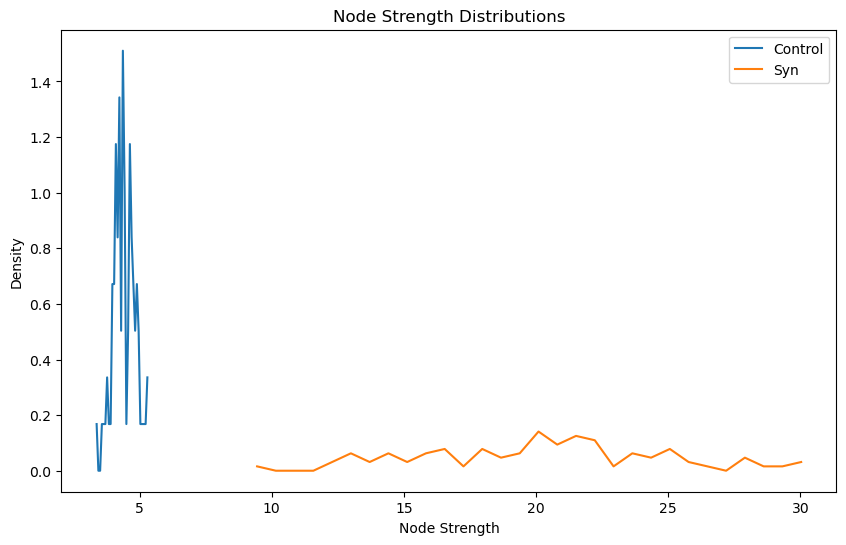

In [4]:
datapath = '/workspace/shared/synesthesia_100brains/surface_area/' # set path to data
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_nn90_avg.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

This data contains absolute surface area data averaged within 90 clusters. The clusters were identified from nearest neighbour joining of absolute surface area in 650 controls.

The node degree distributions look very different between groups. Will this be the same if we use resampled data from the controls so the sample sizes match?

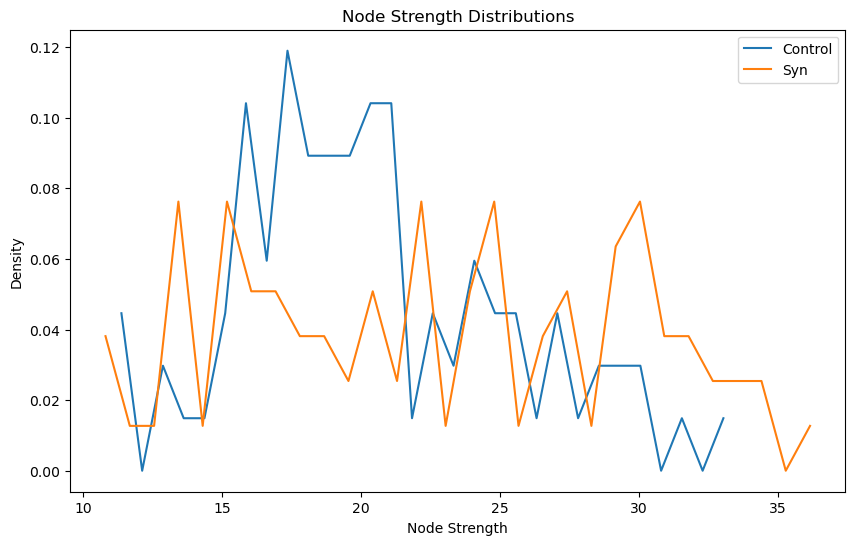

In [4]:
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_nn90_avg_resamp.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

This data contains absolute surface areas averaged within clusters, but for 102 controls as well as 102 synesthetes.
NB: The clusters are still derived from the nearest neighbour clustering of the full 650 controls.

The strength distributions are more similar for this resampled data.
This suggests that even for a reduced number of nodes, partial correlations are still affected by sample size.
We should retry for a smaller number of nodes, obtained through a different clustering algorithm.

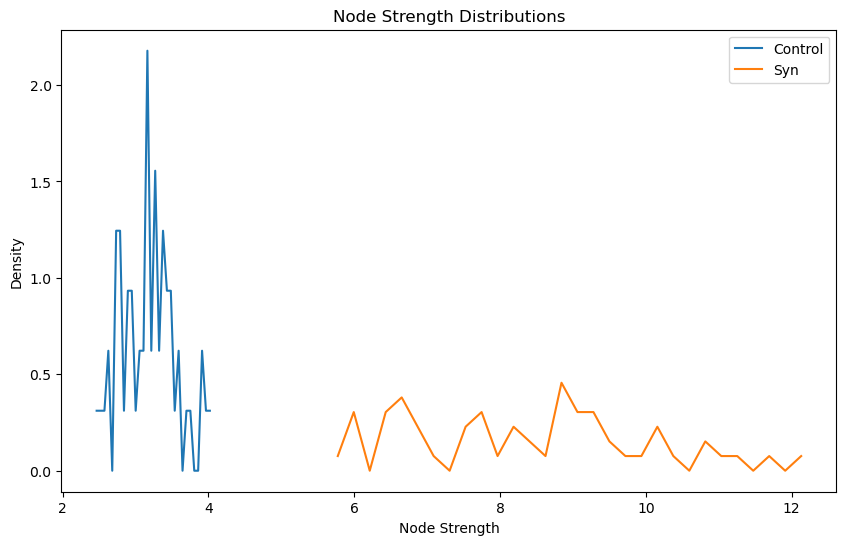

In [67]:
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_wrd60_avg.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

This data contains absolute surface area data averaged within 60 clusters. The clusters were identified from Ward's clustering of absolute surface area in 650 controls.

A very similar pattern to that observed with the 90 clusters. Let's try resampling again.

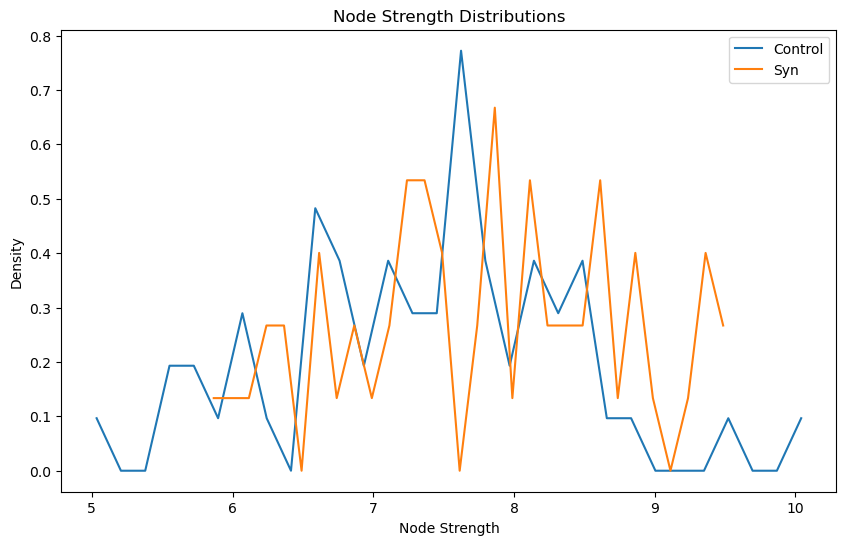

In [5]:
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_wrd60_avg_resamp.csv', 'Syn')
networkfuncs.plot_strengths(graphs)

This data contains absolute surface areas averaged within clusters, but for 102 controls as well as 102 synesthetes.
NB: The clusters are still derived from the Ward's clustering of the full 650 controls.

Again, with resampling, the distributions now overlap. We can probably conclude that for any meaningful number of clusters - at least those obtained through hierarchical clustering - we will probably have to resample the control group to avoid mismatched comparisons between the two groups. From here, let's try running some graph analysis on the nearest neighbour cluster data (90 clusters).

   clustering  efficiency     L_obs   mean_eb   mean_vb    Group
0    0.273285    0.296648  1.877578  0.000395  0.006631  Control
1    0.322047    0.317875  1.785981  0.000383  0.006061      Syn


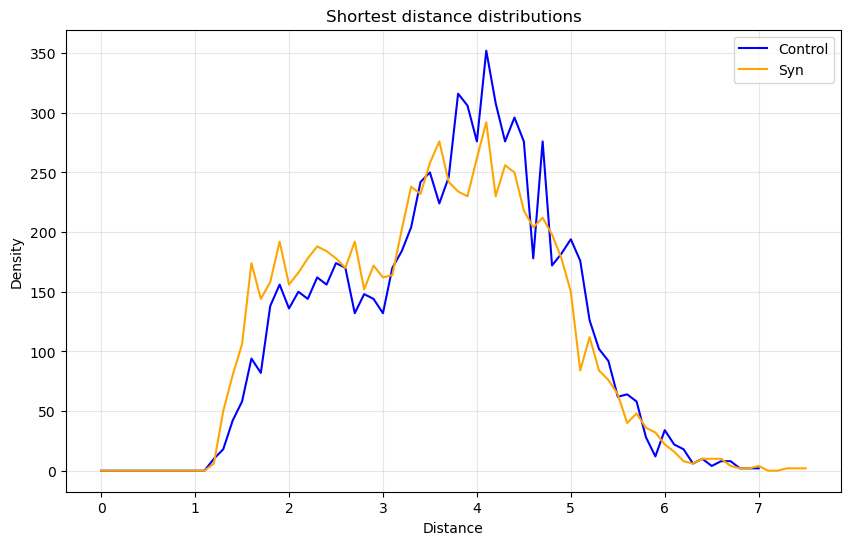

In [7]:
# Re-generate the desired graphs and get the network metrics
datapath = '/workspace/shared/synesthesia_100brains/surface_area/' # set path to data
graphs = networkfuncs.data_to_graphs(datapath+'SA_abs_nn90_avg_resamp.csv', 'Syn') # re-generate graphs

net_metrics = [] # initialise metric list
dist_hists = [] # initialise shortest distance hist list
for graph, group_name in zip(graphs, ['Control', 'Syn']): # for each graph and group
    net_metric = networkfuncs.measure_net(graph) # get the network metrics
    dist_hists.append(net_metric[1]) # add histogram to list
    df = net_metric[0] # get metrics
    df['Group'] = group_name # get the group name
    net_metrics.append(df) # add net metrics to list
    
net_metrics = pd.concat(net_metrics, ignore_index=True) # turn network metrics into one df
print(net_metrics) # print results

plt.figure(figsize=(10, 6))

plt.plot(dist_hists[0][1][:-1], dist_hists[0][0], label="Control", color="blue")
plt.plot(dist_hists[1][1][:-1], dist_hists[1][0], label="Syn", color="orange")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Shortest distance distributions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Increased clustering and efficiency; decreased path length and betweenness in synesthetes. There is also an overall shift of shortest path lengths to lower values, accompanied by a reduction in the number of moderate-distance paths which are most numerous in controls.

We should see if this trend holds and is significant for various resamples of the control dataset.